In [1]:
!pip install customized_konlpy

     |████████████████████████████████| 890kB 6.0MB/s 
     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 460kB 49.4MB/s 
     |████████████████████████████████| 92kB 9.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [2]:
from ckonlpy.tag import Twitter

In [3]:
twitter = Twitter()
twitter.morphs('은경이는 사무실로 갔습니다')

/usr/local/lib/python3.6/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['은', '경이', '는', '사무실', '로', '갔습니다']

In [4]:
twitter.add_dictionary('은경이','Noun')

In [5]:
twitter.morphs('은경이는 사무실로 갔습니다')

['은경이', '는', '사무실', '로', '갔습니다']

In [6]:
from ckonlpy.tag import Twitter
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
from nltk import FreqDist
from functools import reduce
import os
import re
import matplotlib.pyplot as plt

In [7]:
dir


<function dir>

In [8]:
ls


qa1_single-supporting-fact_test_kor.txt   sample_data/
qa1_single-supporting-fact_train_kor.txt


In [9]:
TRAIN_FILE = os.path.join("qa1_single-supporting-fact_train_kor.txt")
TEST_FILE = os.path.join("qa1_single-supporting-fact_test_kor.txt")

In [11]:
i= 0 
lines = open(TRAIN_FILE,"rb")
for line in lines:
  line = line.decode("utf-8").strip()
  i = i +1
  print(line)
  if i == 20:
    break


1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


In [12]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

NameError: ignored

In [13]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []

        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [14]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [15]:
#데이터의 구성을 확인하기 위해서 스토리, 질문, 답변을 각각 분리해서 로드한다.
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [16]:
print('훈련용 스토리의 개수 : ', len(train_stories))


훈련용 스토리의 개수 :  10000


In [17]:
print('훈련용 질문의 개수 : ', len(train_questions))

훈련용 질문의 개수 :  10000


In [18]:
print('훈련용 답변의 개수 :',len(train_answers))
print('테스트용 스토리의 개수 :',len(test_stories))
print('테스트용 질문의 개수 :',len(test_questions))
print('테스트용 답변의 개수 :',len(test_answers))

훈련용 답변의 개수 : 10000
테스트용 스토리의 개수 : 1000
테스트용 질문의 개수 : 1000
테스트용 답변의 개수 : 1000


In [19]:
train_data

([['필웅이는 화장실로 갔습니다.', '은경이는 복도로 이동했습니다.'],
  ['필웅이는 화장실로 갔습니다.',
   '은경이는 복도로 이동했습니다.',
   '수종이는 복도로 복귀했습니다.',
   '경임이는 정원으로 갔습니다.'],
  ['필웅이는 화장실로 갔습니다.',
   '은경이는 복도로 이동했습니다.',
   '수종이는 복도로 복귀했습니다.',
   '경임이는 정원으로 갔습니다.',
   '은경이는 사무실로 갔습니다.',
   '경임이는 화장실로 뛰어갔습니다.'],
  ['필웅이는 화장실로 갔습니다.',
   '은경이는 복도로 이동했습니다.',
   '수종이는 복도로 복귀했습니다.',
   '경임이는 정원으로 갔습니다.',
   '은경이는 사무실로 갔습니다.',
   '경임이는 화장실로 뛰어갔습니다.',
   '필웅이는 복도로 갔습니다.',
   '수종이는 사무실로 가버렸습니다.'],
  ['필웅이는 화장실로 갔습니다.',
   '은경이는 복도로 이동했습니다.',
   '수종이는 복도로 복귀했습니다.',
   '경임이는 정원으로 갔습니다.',
   '은경이는 사무실로 갔습니다.',
   '경임이는 화장실로 뛰어갔습니다.',
   '필웅이는 복도로 갔습니다.',
   '수종이는 사무실로 가버렸습니다.',
   '은경이는 정원으로 복귀했습니다.',
   '은경이는 침실로 갔습니다.'],
  ['경임이는 사무실로 가버렸습니다.', '경임이는 화장실로 이동했습니다.'],
  ['경임이는 사무실로 가버렸습니다.',
   '경임이는 화장실로 이동했습니다.',
   '필웅이는 침실로 이동했습니다.',
   '수종이는 복도로 갔습니다.'],
  ['경임이는 사무실로 가버렸습니다.',
   '경임이는 화장실로 이동했습니다.',
   '필웅이는 침실로 이동했습니다.',
   '수종이는 복도로 갔습니다.',
   '은경이는 정원으로 이동했습니다.',
   '은경이는 사무실로 가버렸습니다.'],
  ['경임이는 사무실로 가버렸습니다.',
   '경임이는 화장실로 이동

In [20]:
len(train_data)

3

In [21]:
train_stories[3572]

['은경이는 부엌으로 가버렸습니다.',
 '필웅이는 사무실로 가버렸습니다.',
 '수종이는 복도로 뛰어갔습니다.',
 '은경이는 사무실로 복귀했습니다.',
 '경임이는 사무실로 이동했습니다.',
 '경임이는 침실로 갔습니다.']

In [22]:
train_questions[3572]

'은경이는 어디야? '

In [23]:
train_answers[3572]

'사무실'

In [24]:
def tokenize(sent):
  return [x.strip() for x in re.split('(\W+)?',sent) if x.strip()]


In [25]:
def preprocess_data(train_data, test_data):
  counter = FreqDist()

  #두 문장의 스토리를 하나의 문장으로 통합
  flatten = lambda data: reduce(lambda x, y: x+y,data)

  #각 샘플의 길이를 저장하는 리스트
  story_len = []
  question_len = []

  for stories, questions, answers in [train_data, test_data]:
    for story in stories:
      stories = tokenize(flatten(story))#스토리의 문장들을 펼친 후 토큰화
      story_len.append(len(stories)) #각 story의 길이 저장
      for word in stories: #단어 집합에 단어 추가
        counter[word] +=1
    for question in questions:
      question = tokenize(question)
      question_len.append(len(question))
      for word in question:
        counter[word] +=1
    for answer in answers:
      answer = tokenize(answer)
      for word in answer:
        counter[word] += 1
      
    # 단어 집합 생성
  word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
  idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
  story_max_len = np.max(story_len)
  question_max_len = np.max(question_len)

  return word2idx, idx2word, story_max_len, question_max_len


In [26]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [27]:
print(word2idx)

{'.': 1, '경임이는': 2, '은경이는': 3, '수종이는': 4, '필웅이는': 5, '이동했습니다': 6, '가버렸습니다': 7, '뛰어갔습니다': 8, '복귀했습니다': 9, '갔습니다': 10, '화장실로': 11, '정원으로': 12, '복도로': 13, '어디야': 14, '?': 15, '부엌으로': 16, '사무실로': 17, '침실로': 18, '화장실': 19, '정원': 20, '사무실': 21, '침실': 22, '복도': 23, '부엌': 24}


In [28]:
twitter.add_dictionary('은경이', 'Noun')
twitter.add_dictionary('경임이', 'Noun')
twitter.add_dictionary('수종이', 'Noun')

In [29]:
def tokenize(sent):
    return twitter.morphs(sent)

In [30]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [31]:
print(word2idx)

{'는': 1, '.': 2, '로': 3, '했습니다': 4, '으로': 5, '경임이': 6, '은경이': 7, '수종이': 8, '필웅이': 9, '이동': 10, '가버렸습니다': 11, '뛰어갔습니다': 12, '복귀': 13, '화장실': 14, '정원': 15, '복도': 16, '갔습니다': 17, '사무실': 18, '부엌': 19, '침실': 20, '어디': 21, '야': 22, '?': 23}


In [32]:
vocab_size = len(word2idx) + 1
print(vocab_size)

24


In [33]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 70
질문의 최대 길이 : 5


In [35]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
  Xs, Xq, Y = [], [], []
  flatten = lambda data: reduce(lambda x, y: x + y, data)

  stories, questions, answers = data
  for story, question, answer in zip(stories, questions, answers):
      xs = [word2idx[w] for w in tokenize(flatten(story))]
      xq = [word2idx[w] for w in tokenize(question)]
      Xs.append(xs)
      Xq.append(xq)
      Y.append(word2idx[answer])

        # 스토리와 질문은 각각의 최대 길이로 패딩
        # 정답은 원-핫 인코딩
  return pad_sequences(Xs, maxlen=story_maxlen),\
          pad_sequences(Xq, maxlen=question_maxlen),\
          to_categorical(Y, num_classes=len(word2idx) + 1)

In [36]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [37]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 70) (10000, 5) (10000, 24) (1000, 70) (1000, 5) (1000, 24)


In [38]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation

In [39]:
#에포크 횟수
train_epoch = 120
#배치 크기
batch_size = 32
#임베딩 크기
embed_size = 50
#LSTM의 크기
lstm_size = 64
#과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [40]:
#플레이스 홀터, 입력을 담는 변수
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))

print('Stroies : ',input_sequence)
print('Questions: ',question)



Stroies :  KerasTensor(type_spec=TensorSpec(shape=(None, 70), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Questions:  KerasTensor(type_spec=TensorSpec(shape=(None, 5), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [42]:
#스토리를 위한 첫번째 임베딩, 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim = embed_size))
input_encoder_m.add(Dropout(dropout_rate))

In [43]:
# 스토리를 위한 두번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))

In [44]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embedding_dim) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [45]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 70, 50), dtype=tf.float32, name=None), name='sequential_1/dropout/Identity:0', description="created by layer 'sequential_1'")
Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 70, 5), dtype=tf.float32, name=None), name='sequential_2/dropout_1/Identity:0', description="created by layer 'sequential_2'")
Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 5, 50), dtype=tf.float32, name=None), name='sequential_3/dropout_2/Identity:0', description="created by layer 'sequential_3'")


In [46]:
#스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
#유사도는 내적을 사요한다
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)

Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 70, 5), dtype=tf.float32, name=None), name='activation/truediv:0', description="created by layer 'activation'")


In [47]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_max_len, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_max_len)
print('Response shape', response)

# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)

answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 5, 70), dtype=tf.float32, name=None), name='permute/transpose:0', description="created by layer 'permute'")
Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 5, 120), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [48]:
# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, None, 50)     1200        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 5, 50)        1200        input_2[0][0]                    
______________________________________________________________________________________________

In [50]:
# start training the model
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epoch,
         validation_data=([Xstest, Xqtest], Ytest))

model.save('model.h5')

313/313 [==============================] - 3s 10ms/step - loss: 0.9388 - acc: 0.6119 - val_loss: 0.9519 - val_acc: 0.6330
Epoch 37/120
313/313 [==============================] - 3s 10ms/step - loss: 0.7726 - acc: 0.7005 - val_loss: 0.7413 - val_acc: 0.7230
Epoch 38/120
313/313 [==============================] - 3s 10ms/step - loss: 0.6262 - acc: 0.7662 - val_loss: 0.7110 - val_acc: 0.7480
Epoch 39/120
313/313 [==============================] - 3s 10ms/step - loss: 0.5809 - acc: 0.7879 - val_loss: 0.6509 - val_acc: 0.7590
Epoch 40/120
313/313 [==============================] - 3s 10ms/step - loss: 0.5313 - acc: 0.8064 - val_loss: 0.6090 - val_acc: 0.7680
Epoch 41/120
313/313 [==============================] - 3s 10ms/step - loss: 0.4880 - acc: 0.8168 - val_loss: 0.6092 - val_acc: 0.7730
Epoch 42/120
313/313 [==============================] - 3s 10ms/step - loss: 0.4865 - acc: 0.8189 - val_loss: 0.5483 - val_acc: 0.7940
Epoch 43/120
313/313 [==============================] - 3s 10ms/step

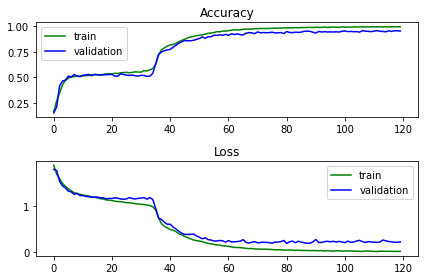

In [51]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [52]:
NUM_DISPLAY = 30

print("{:18}|{:5}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:7} {}".format(question, label, prediction))

질문                |실제값  |예측값
---------------------------------------
은경이 는 어디 야 ?        : 복도      복도
필웅이 는 어디 야 ?        : 화장실     화장실
경임이 는 어디 야 ?        : 부엌      부엌
경임이 는 어디 야 ?        : 복도      복도
경임이 는 어디 야 ?        : 부엌      부엌
경임이 는 어디 야 ?        : 복도      복도
경임이 는 어디 야 ?        : 정원      정원
수종이 는 어디 야 ?        : 복도      복도
경임이 는 어디 야 ?        : 사무실     사무실
수종이 는 어디 야 ?        : 사무실     침실
필웅이 는 어디 야 ?        : 부엌      부엌
필웅이 는 어디 야 ?        : 정원      정원
수종이 는 어디 야 ?        : 사무실     사무실
필웅이 는 어디 야 ?        : 침실      침실
필웅이 는 어디 야 ?        : 침실      침실
은경이 는 어디 야 ?        : 부엌      부엌
은경이 는 어디 야 ?        : 정원      정원
은경이 는 어디 야 ?        : 부엌      부엌
수종이 는 어디 야 ?        : 사무실     사무실
은경이 는 어디 야 ?        : 부엌      복도
필웅이 는 어디 야 ?        : 복도      복도
은경이 는 어디 야 ?        : 사무실     사무실
은경이 는 어디 야 ?        : 사무실     사무실
경임이 는 어디 야 ?        : 복도      복도
수종이 는 어디 야 ?        : 침실      침실
경임이 는 어디 야 ?        : 침실      침실
필웅이 는 어디 야 ?        : 침실      침실
수종이 는 어디 야 ?        : 부엌      부엌
수